In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, max_error

sns.set()

In [2]:
class LFM:
    def __init__(self, alpha, reg_p, reg_q, K=10, epochs=10, columns=[]):
        self.alpha = alpha
        self.reg_p = reg_p   # egulariztion of maxtrix P
        self.reg_q = reg_q   # egulariztion of maxtrix Q
        self.K = K
        self.epochs = epochs
        self.columns = columns
        self.history = []

        
    def _init_matrix(self):
        P = dict(zip(self.users_ratings.index,
                    np.random.rand(len(self.users_ratings), self.K).astype(np.float32)
            ))
        Q = dict(zip(self.items_ratings.index,
                    np.random.rand(len(self.items_ratings), self.K).astype(np.float32)
            ))
        
        return P, Q
    
    def sgd(self):
        P, Q = self._init_matrix()
        
        for i in range(self.epochs):
            
            error_list = []
            for uid, iid, r_ui in self.dataset.itertuples(index=False):
                v_pu = P[uid]
                v_qi = Q[iid]
                err = np.float32(r_ui - np.dot(v_pu,v_qi))
                
                v_pu += self.alpha* (err * v_qi - self.reg_p * v_pu)
                v_qi += self.alpha* (err * v_pu - self.reg_p * v_qi)
                
                P[uid] = v_pu
                Q[iid] = v_qi
                
                error_list.append(err**2)
                
            if i%5==0:
                print(f'iter-{i}  MSE = {err**2}')
            self.history.append(np.sqrt(np.mean(error_list)))        
        return P, Q
    
    def fit(self, dataset):
        self.dataset = pd.DataFrame(dataset)
        
        self.users_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1],self.columns[2]]]
        self.items_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0],self.columns[2]]]
        self.P, self.Q = self.sgd()
    
    def predict(self):
        P = np.array(list(lfm.P.values()))
        Q = np.array(list(lfm.Q.values()))

        prediction = pd.DataFrame(np.dot(P, Q.T))
        prediction.index = dataset['userId'].unique()
        prediction.columns = dataset['movieId'].unique()

        prediction = prediction.unstack().to_frame().reset_index()
        prediction.columns = ['movieId','userId','prediction']
        return prediction

In [3]:
dtype = [('userId', np.int32), ('movieId', np.int32), ('rating', np.float32)]
dataset = pd.read_csv('ml-latest-small/ratings.csv', dtype=dict(dtype), usecols=range(3))

In [4]:
dataset.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


In [33]:
lfm = LFM(0.001, 0, 0, epochs=200, columns=['userId','movieId','rating'])
lfm.fit(dataset)

iter-0  MSE = 1.7022828840183593
iter-5  MSE = 1.1847243425372653
iter-10  MSE = 0.848483005314904
iter-15  MSE = 0.642344290661697
iter-20  MSE = 0.5033500967556392
iter-25  MSE = 0.402873523471726
iter-30  MSE = 0.3263989795325415
iter-35  MSE = 0.26603734172476834
iter-40  MSE = 0.21721785236513824
iter-45  MSE = 0.17713040807626612
iter-50  MSE = 0.14392429075451219
iter-55  MSE = 0.11630284425700665
iter-60  MSE = 0.09330871017391473
iter-65  MSE = 0.07419755036244169
iter-70  MSE = 0.058367697633968874
iter-75  MSE = 0.04532404245401267
iter-80  MSE = 0.03465007480940585
iter-85  MSE = 0.02598945219892812
iter-90  MSE = 0.01903821288783547
iter-95  MSE = 0.013535254817043096
iter-100  MSE = 0.009252878371853512
iter-105  MSE = 0.005996920301413411
iter-110  MSE = 0.003599363736611849
iter-115  MSE = 0.0019160699144435966
iter-120  MSE = 0.0008234501866013488
iter-125  MSE = 0.0002155627249180725
iter-130  MSE = 2.766260877251625e-06
iter-135  MSE = 0.0001088814517515857
iter-140 

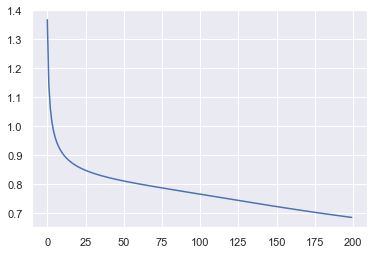

In [48]:
plt.plot(lfm.history, '-')

In [49]:
prediction = lfm.predict()
prediction

,movieId,userId,prediction
0,1,1,4.644064
1,1,2,3.800160
2,1,3,1.503404
3,1,4,3.157749
4,1,5,4.005111
...,...,...,...
5931635,163981,606,4.147664
5931636,163981,607,3.512741
5931637,163981,608,3.580937
5931638,163981,609,4.002397


In [37]:
prediction_real = dataset.merge(prediction, how='inner', on=['userId','movieId'])

In [38]:
prediction_real

,userId,movieId,rating,prediction
0,1,1,4.0,4.644064
1,1,3,4.0,4.298036
2,1,6,4.0,3.937638
3,1,47,5.0,2.967694
4,1,50,5.0,3.518228
...,...,...,...,...
100831,610,166534,4.0,3.144808
100832,610,168248,5.0,3.367908
100833,610,168250,5.0,3.293264
100834,610,168252,5.0,2.799730


In [39]:
r2_score(prediction_real['rating'], prediction_real['prediction'])

-0.32851570196944757

In [40]:
mean_absolute_error(prediction_real['rating'], prediction_real['prediction'])

0.95280874

<AxesSubplot:title={'center':'Residual distribution'}, ylabel='Frequency'>

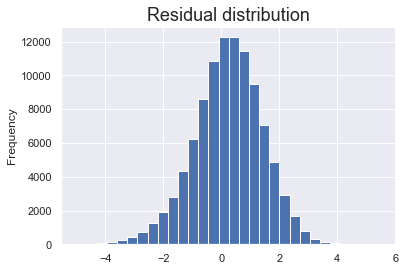

In [41]:
error = prediction_real['rating'] - prediction_real['prediction']
plt.title('Residual distribution', fontsize=18)
error.plot(kind='hist', bins=30)

In [42]:
error.mean(), error.std()

(0.2338278889656067, 1.1786539554595947)